### Process Data Functions

In [116]:
import re
import pandas as pd

# Try to use orjson for speed; fall back to stdlib json
try:
    import orjson as _json
    def _loads(b): return _json.loads(b)
except Exception:
    import json as _json
    def _loads(b): return _json.loads(b)

# Precompiled split for metadata lines
_META_SPLIT = re.compile(r'\s*::\s*')

# --------------------------
# Fast, vectorized helpers
# --------------------------
def _to_pacific_series(utc_series: pd.Series) -> pd.Series:
    """Convert a UTC tz-aware datetime Series to America/Los_Angeles."""
    # utc_series must be tz-aware UTC; .dt.tz_convert is vectorized
    return utc_series.dt.tz_convert("America/Los_Angeles")

# --------------------------
# Fanatics ProbabilityUpdates (faster)
# --------------------------
def process_probability_file_fast(file_path, filter_market_id=None, filter_selection_id=None):
    """
    Faster version:
    - Streams file
    - Early filters to reduce rows
    - Single vectorized timezone pass
    """
    def parse_metadata(metadata_line: str):
        parts = _META_SPLIT.split(metadata_line.strip())
        if len(parts) < 6:
            # Skip bad metadata lines instead of raising (faster & resilient)
            return None
        return {
            "Timestamp": parts[0].strip() if len(parts) > 0 else "",
            "FixtureId_Metadata": parts[1].strip() if len(parts) > 1 else "",
            "CorrelationId": parts[2].split("=", 1)[1].strip() if len(parts) > 2 and "corrId=" in parts[2] else "",
            "MessageId": parts[3].split("=", 1)[1].strip() if len(parts) > 3 and "msgId=" in parts[3] else "",
            "UnknownValue": parts[4].strip() if len(parts) > 4 else "",
            "ServicePath": parts[5].strip() if len(parts) > 5 else "",
            "EventName": parts[-1].strip() if len(parts) > 6 else ""
        }

    rows = []
    current_metadata = None

    with open(file_path, "rb") as f:  # rb lets orjson avoid extra decoding
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # Metadata lines contain " :: "
            if b" :: " in line:
                md = parse_metadata(line.decode("utf-8", errors="ignore"))
                current_metadata = md
                continue

            # JSON lines
            if line.startswith(b"{") and line.endswith(b"}"):
                try:
                    obj = _loads(line)
                except Exception:
                    continue
                if not current_metadata:
                    continue

                fixture_id = obj.get("FixtureId")
                market_updates = obj.get("MarketUpdates") or obj.get("Markets") or []

                for market in market_updates:
                    market_id = market.get("MarketDefinitionId")
                    # Early market filter (optional)
                    if filter_market_id is not None and market_id != filter_market_id:
                        continue

                    selection_updates = market.get("SelectionUpdates") or []
                    for sel in selection_updates:
                        sel_id = sel.get("SelectionDefinitionId")
                        if (filter_selection_id is not None) and (sel_id != filter_selection_id):
                            continue

                        rows.append({
                            "FixtureId": fixture_id,
                            "MarketDefinitionId": sel.get("MarketDefinitionId", market_id),
                            "SelectionDefinitionId": sel_id,
                            "UpdatedProbability": sel.get("UpdatedProbability"),
                            "Timestamp": current_metadata.get("Timestamp"),
                            "FixtureId_Metadata": current_metadata.get("FixtureId_Metadata"),
                            "CorrelationId": current_metadata.get("CorrelationId"),
                            "MessageId": current_metadata.get("MessageId"),
                            "UnknownValue": current_metadata.get("UnknownValue"),
                            "ServicePath": current_metadata.get("ServicePath"),
                            "EventName": current_metadata.get("EventName"),
                        })

    if not rows:
        return pd.DataFrame(columns=[
            "FixtureId","MarketDefinitionId","SelectionDefinitionId",
            "UpdatedProbability","Timestamp","TimestampUtc",
            "ReceiveTimestampPacific","ReceiveTimestampPacific_HMS",
            "FixtureId_Metadata","CorrelationId","MessageId",
            "UnknownValue","ServicePath","EventName"
        ])

    df = pd.DataFrame(rows)

    # Single vectorized conversion: assume naive timestamps are UTC, coerce errors to NaT
    # utc=True ensures tz-aware UTC output even if inputs carry tz info
    df["TimestampUtc"] = pd.to_datetime(df["Timestamp"], utc=True, errors="coerce")

    df["ReceiveTimestampPacific"] = _to_pacific_series(df["TimestampUtc"])
    # dt.strftime is vectorized; avoid a Python lambda
    df["ReceiveTimestampPacific_HMS"] = df["ReceiveTimestampPacific"].dt.strftime("%H:%M:%S")

    return df

# --------------------------
# TxOdds Fusion (faster)
# --------------------------
def process_tx_odds_fast(file_path, want_moneyline_only=True, want_full_period_only=True, want_not_suspended=True):
    """
    Faster version:
    - Streams file (no readlines)
    - Early filters (Moneyline/Full/!Suspended)
    - Single vectorized timestamp conversion (UTC -> Pacific derived if needed)
    """
    out = []

    with open(file_path, "rb") as f:
        for raw in f:
            line = raw.strip()
            if not line or not (line.startswith(b"{") and line.endswith(b"}")):
                continue
            try:
                obj = _loads(line)
            except Exception:
                continue

            fixture = obj.get("FixtureId") or {}
            common = {
                "FixtureId": (fixture.get("Id") if isinstance(fixture, dict) else None),
                "ClientId": (fixture.get("ClientId") if isinstance(fixture, dict) else None),
                "IsOfferedInPlay": obj.get("IsOfferedInPlay"),
            }

            moneylines = obj.get("MoneylineUpdates") or []
            for m in moneylines:
                if want_full_period_only and m.get("PeriodType") != "Full":
                    continue
                if want_not_suspended and m.get("IsSuspended") is True:
                    continue

                rec = {
                    **common,
                    "market_type": "MoneylineUpdates",
                    "LastUpdateTimestampUtc": m.get("LastUpdateTimestampUtc"),
                    "ReceiveTimestampUtc": m.get("ReceiveTimestampUtc"),
                    "HomePrice": m.get("HomePrice"),
                    "AwayPrice": m.get("AwayPrice"),
                    "IsSuspended": m.get("IsSuspended"),
                    "SourceBookmaker": m.get("SourceBookmaker"),
                    "PeriodType": m.get("PeriodType"),
                }
                out.append(rec)

            # If you need other markets, add similar loops here,
            # but filtering early like above.

            if want_moneyline_only:
                continue

    if not out:
        return pd.DataFrame(columns=[
            "FixtureId","ClientId","IsOfferedInPlay","market_type",
            "LastUpdateTimestampUtc","ReceiveTimestampUtc",
            "TimestampUtc","ReceiveTimestampPacific",
            "HomePrice","AwayPrice","IsSuspended","SourceBookmaker","PeriodType"
        ])

    df = pd.DataFrame(out)

    # Choose a single canonical timestamp column, vectorized
    ts_raw = df["LastUpdateTimestampUtc"].fillna(df["ReceiveTimestampUtc"])
    df["TimestampUtc"] = pd.to_datetime(ts_raw, utc=True, errors="coerce")
    df["ReceiveTimestampPacific"] = _to_pacific_series(df["TimestampUtc"])

    return df

import re
import pandas as pd

def build_fixture_df(
    fanatics_uat_path: str,
    fanatics_prod_path: str,
    txodds_path: str,
    *,
    fixture_name: str | None = None,
    filter_market_id: int = 1,
    filter_selection_id: int = 1
) -> pd.DataFrame:
    """
    Build a merged DataFrame for a single fixture from 3 files:
      - Fanatics UAT ProbabilityUpdates
      - Fanatics PROD ProbabilityUpdates
      - TxOdds Fusion In-Play Events

    Returns a DataFrame with columns at least:
      ['TimestampUtc','probability','book','timestamp_pacific','fixture']
    """

    # --- Fanatics UAT ---
    df_uat = process_probability_file_fast(
        fanatics_uat_path, filter_market_id=filter_market_id, filter_selection_id=filter_selection_id
    )[["TimestampUtc", "UpdatedProbability"]].rename(columns={"UpdatedProbability": "probability"})
    df_uat["book"] = "Fanatics UAT"

    # --- Fanatics PROD ---
    df_prod = process_probability_file_fast(
        fanatics_prod_path, filter_market_id=filter_market_id, filter_selection_id=filter_selection_id
    )[["TimestampUtc", "UpdatedProbability"]].rename(columns={"UpdatedProbability": "probability"})
    df_prod["book"] = "Fanatics PROD"

    # --- TxOdds (Moneyline/Full/!Suspended already filtered in helper) ---
    tx = process_tx_odds_fast(
        txodds_path, want_moneyline_only=True, want_full_period_only=True, want_not_suspended=True
    )
    tx["home_prob"] = 1 / tx["HomePrice"]
    tx["away_prob"] = 1 / tx["AwayPrice"]
    denom = tx["home_prob"] + tx["away_prob"]
    tx["probability"] = tx["home_prob"] / denom
    tx = tx[["TimestampUtc", "probability", "SourceBookmaker"]].rename(columns={"SourceBookmaker": "book"})

    # Merge all three
    merged = pd.concat([df_uat, df_prod, tx], ignore_index=True)

    # Add Pacific timestamp (vectorized) + fixture label
    merged["timestamp_pacific"] = merged["TimestampUtc"].dt.tz_convert("America/Los_Angeles")
    if fixture_name:
        merged["fixture"] = fixture_name

    return merged


def build_many_fixtures(fixtures: list[dict], *, create_globals: bool = False):
    """
    fixtures: list of dicts, each like:
      {
        "name": "Browns vs. Eagles (3060575489)",
        "fanatics_uat": r"C:\Temp\...-uat-3060575489-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\...-production-3060575489-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\...-production-3060575489-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
      }

    Returns:
      - fixture_dfs: dict[str, pd.DataFrame] mapping fixture name -> merged df
      - combined_df: pd.DataFrame concatenating all fixtures (adds 'fixture' column)
    """
    fixture_dfs: dict[str, pd.DataFrame] = {}

    for f in fixtures:
        name = f.get("name") or "fixture"
        df = build_fixture_df(
            f["fanatics_uat"],
            f["fanatics_prod"],
            f["txodds"],
            fixture_name=name
        )
        fixture_dfs[name] = df

        # OPTIONAL: dynamically create variables (not recommended, but provided)
        if create_globals:
            # sanitize to a safe variable name
            var_name = re.sub(r"\W+", "_", name).strip("_").lower()
            globals()[var_name] = df  # e.g., "browns_vs_eagles_3060575489"

    # One big DataFrame with a 'fixture' column
    combined_df = pd.concat(fixture_dfs.values(), ignore_index=True)

    return fixture_dfs, combined_df


<>:249: SyntaxWarning: invalid escape sequence '\T'
<>:249: SyntaxWarning: invalid escape sequence '\T'
C:\Users\logan.anthony_betfan\AppData\Local\Temp\ipykernel_30324\12676866.py:249: SyntaxWarning: invalid escape sequence '\T'
  """


### Load/Process Data

In [120]:
fixtures = [
    {
        "name": "49ers @ Raiders (3060575521)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575521-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575521-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575521-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
    {
        "name": "Browns @ Eagles (3060575379)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575379-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575379-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575379-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
    {
        "name": "Jets @ Giants (3060575471)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575471-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575471-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575471-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
    {
        "name": "Ravens @ Cowboys (3060575395)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575395-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575395-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575395-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
    {
        "name": "Dolphins @ Lions (3060575463)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575463-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575463-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575463-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
    {
        "name": "Bills @ Bears (3060575369)",
        "fanatics_uat": r"C:\Temp\all-archive-uat-3060575369-ProbabilityUpdates.AmericanFootball.json",
        "fanatics_prod": r"C:\Temp\all-archive-production-3060575369-ProbabilityUpdates.AmericanFootball.json",
        "txodds": r"C:\Temp\all-archive-production-3060575369-Feeds.TxOdds.Fusion.AmericanFootball.InPlay.Events.json",
    },
]


fixture_dfs, all_fixtures_df = build_many_fixtures(fixtures, create_globals=False)

# Access one fixture:
niners_raiders_df = fixture_dfs["49ers @ Raiders (3060575521)"]
browns_eagles_df = fixture_dfs["Browns @ Eagles (3060575379)"]
jets_giants_df = fixture_dfs["Jets @ Giants (3060575471)"]
ravens_cowboys_df = fixture_dfs["Ravens @ Cowboys (3060575395)"]
dolphins_lions_df = fixture_dfs["Dolphins @ Lions (3060575463)"]
bills_bears_df = fixture_dfs["Bills @ Bears (3060575369)"]

# Or use the combined df:
# print(all_fixtures_df[["fixture", "book", "timestamp_pacific", "probability"]].head())


### Graphing Moneyline Probability in UAT vs. PROD vs. Industry

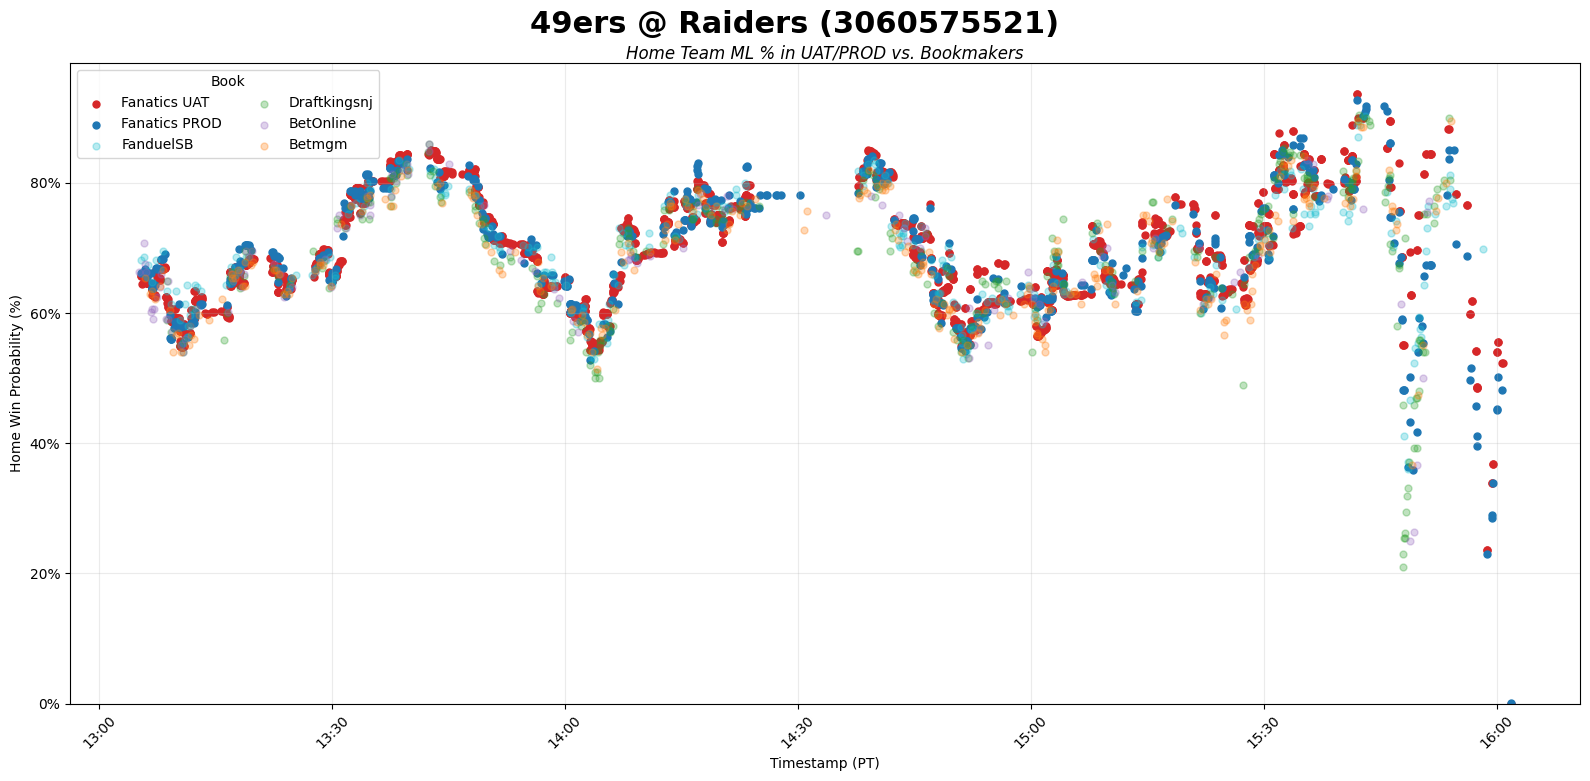

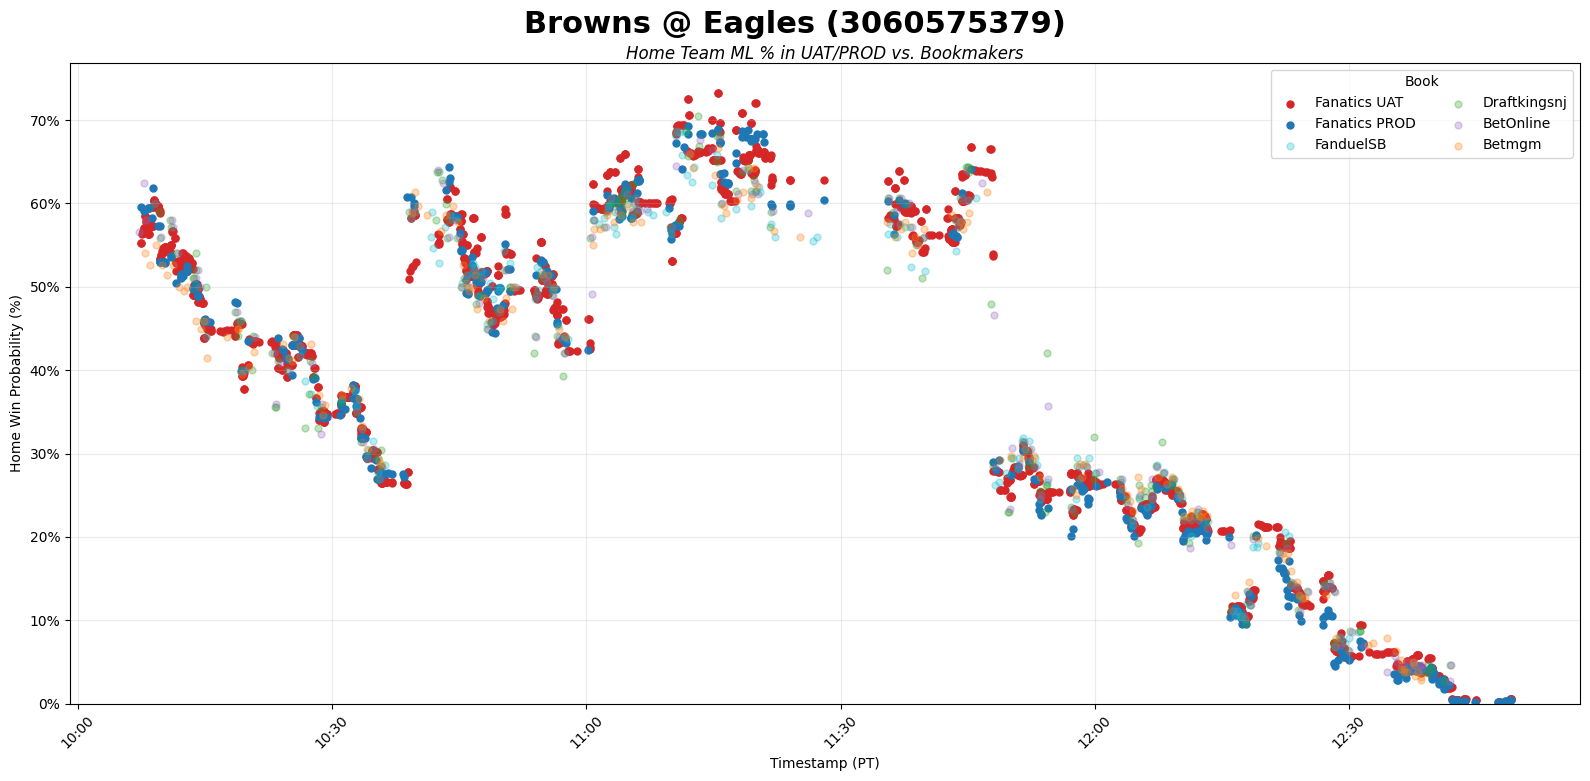

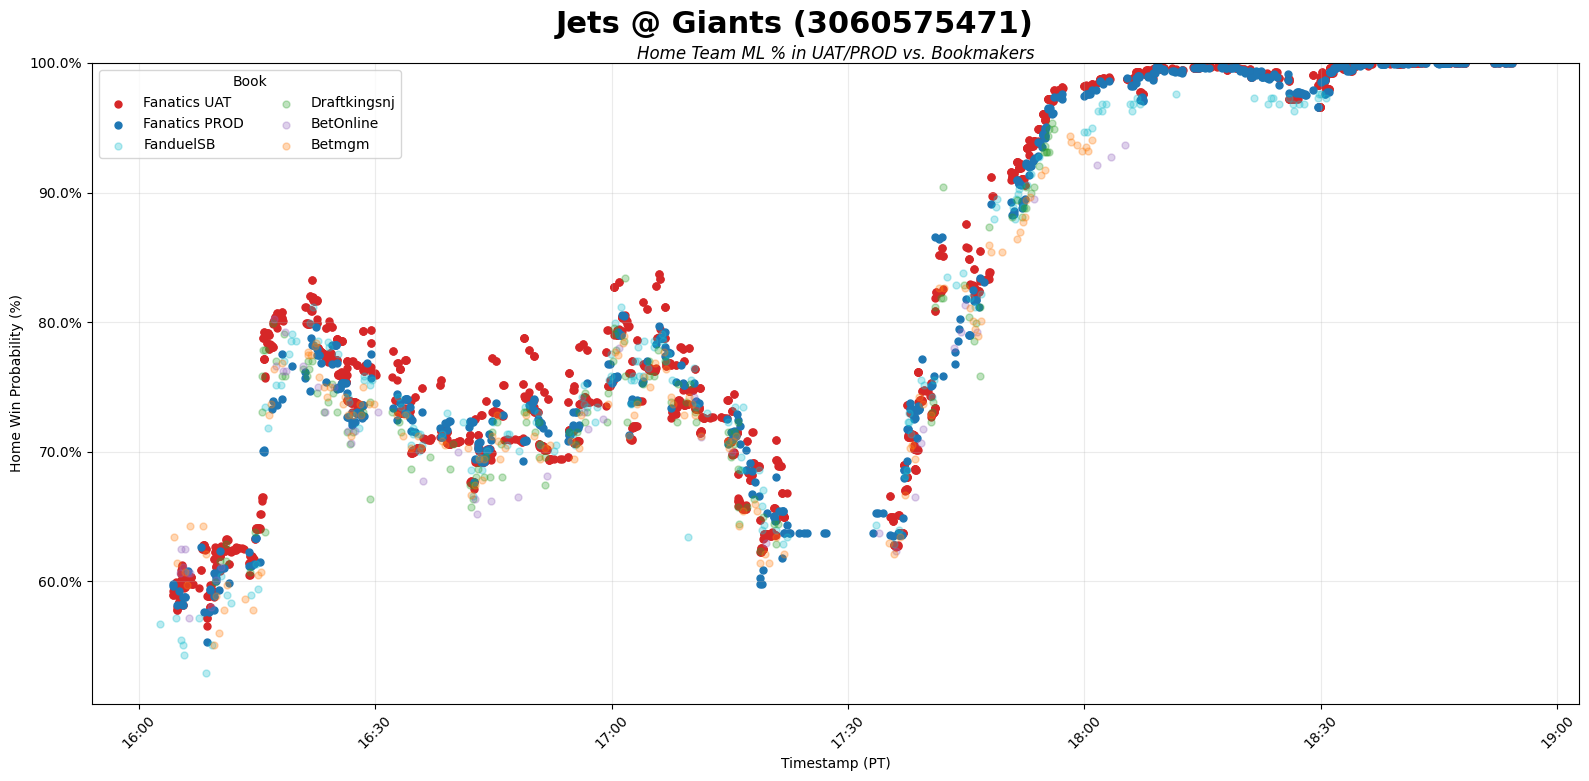

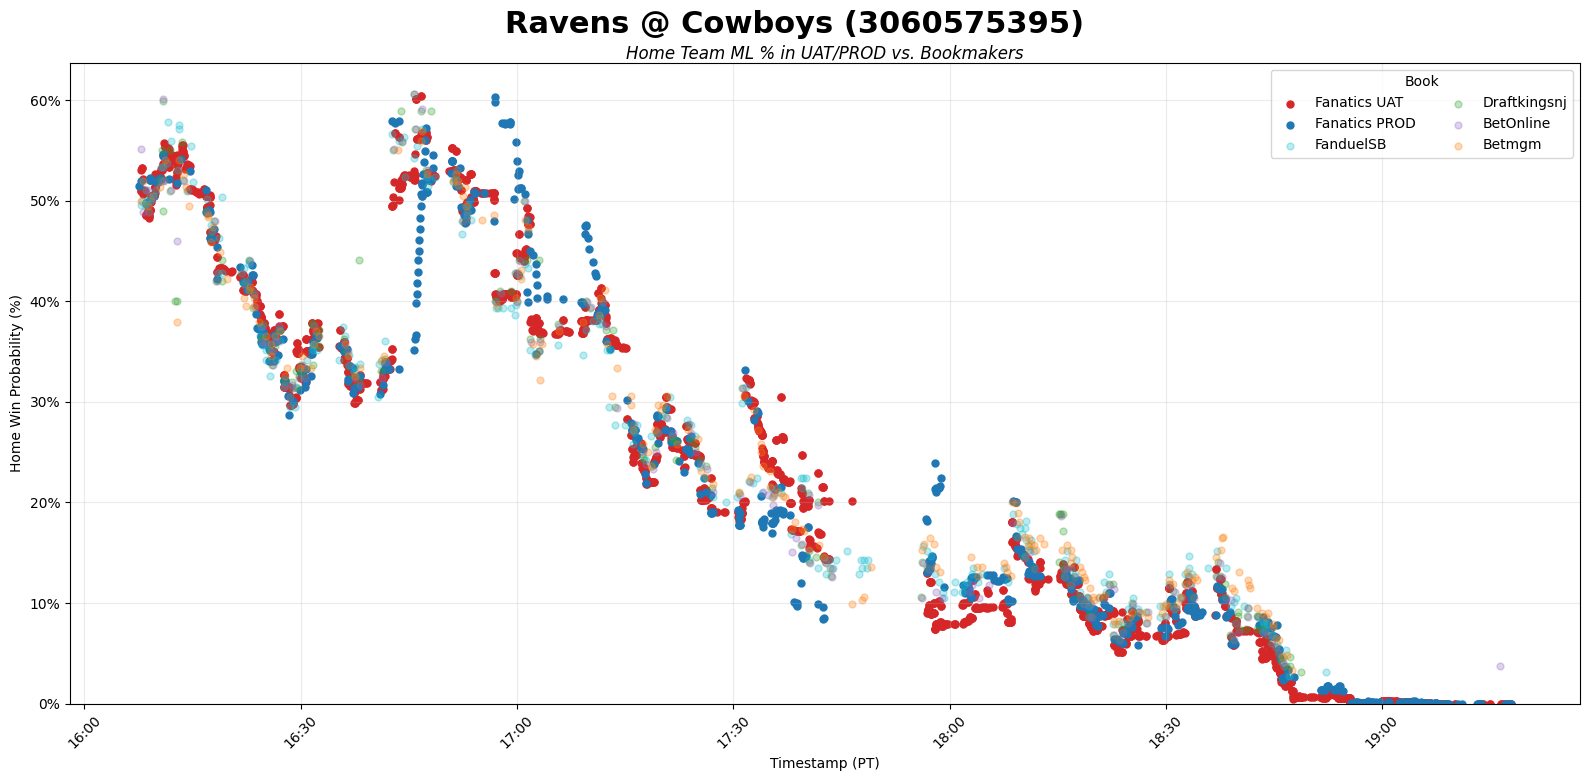

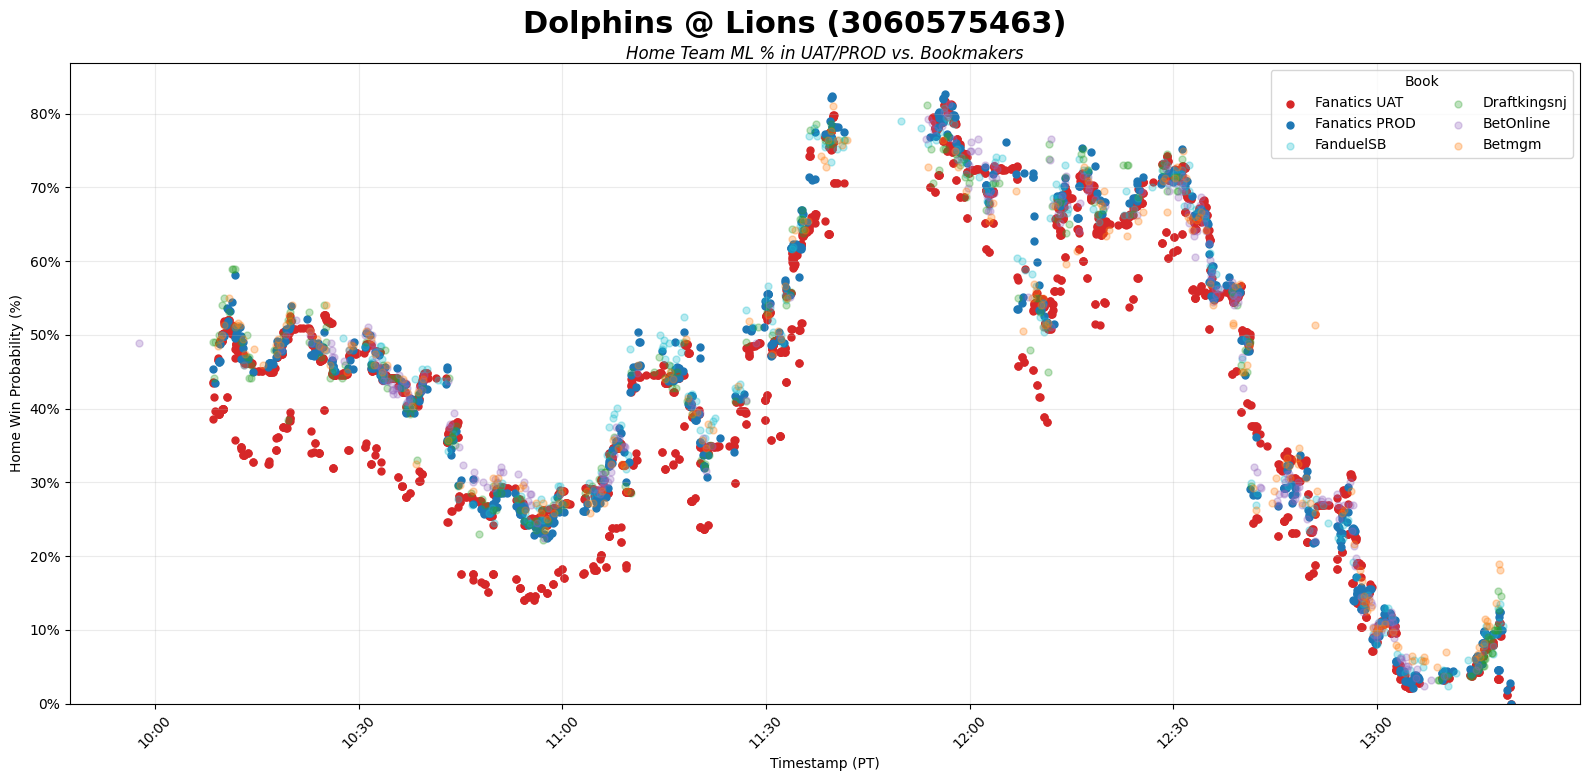

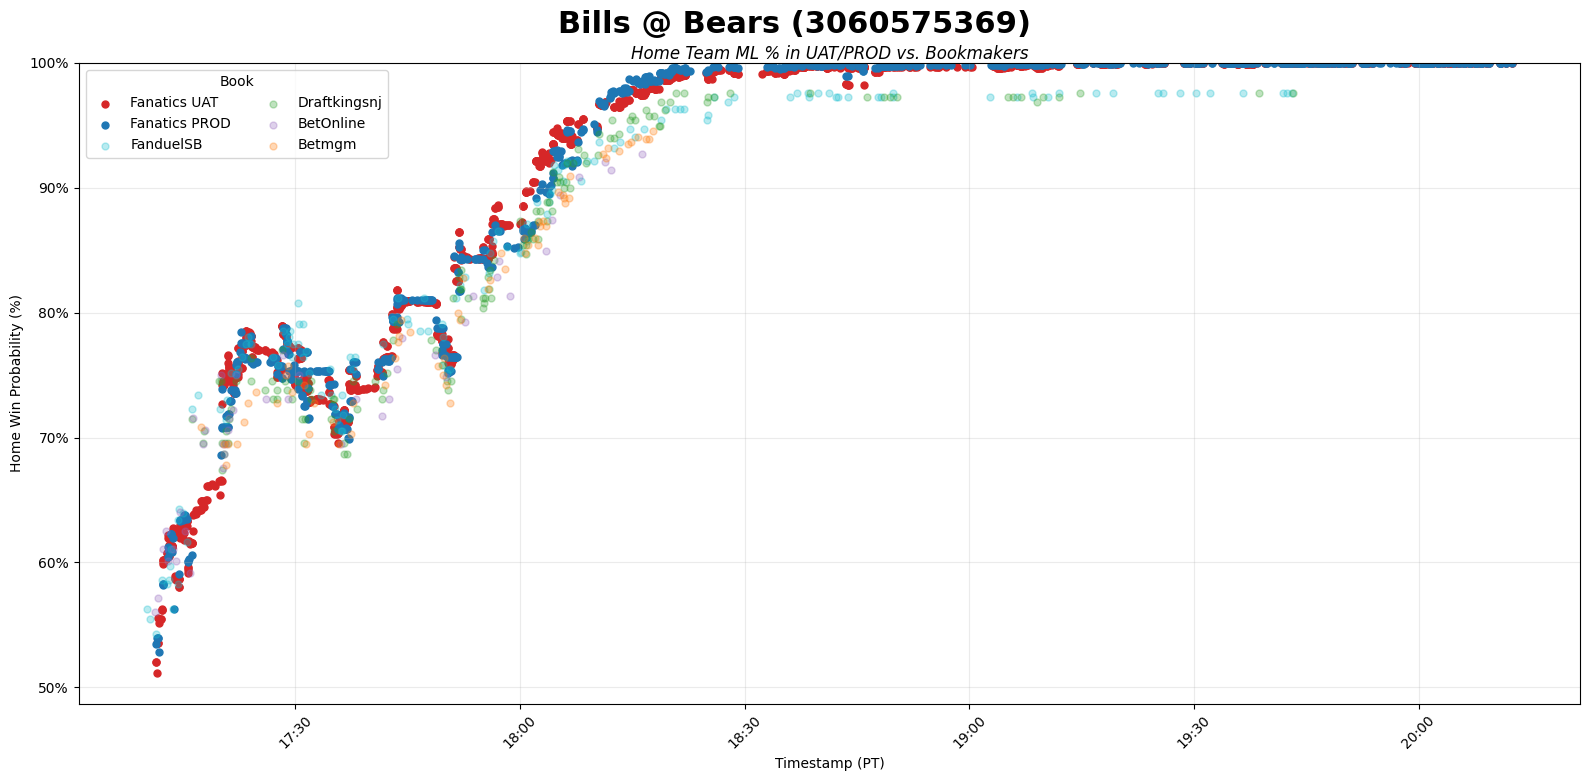

In [122]:
import re
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.ticker import PercentFormatter

# --- Config ---
book_order = ["Fanatics UAT", "Fanatics PROD", "FanduelSB", "Draftkingsnj", "BetOnline", "Betmgm"]
book_colors = {
    "Fanatics UAT": "#d62728",   # red
    "Fanatics PROD": "#1f77b4",  # blue
    "FanduelSB":    "#17becf",   # cyan-ish
    "Draftkingsnj": "#2ca02c",   # green
    "BetOnline":    "#9467bd",   # purple
    "Betmgm":       "#ff7f0e",   # orange
}
subtitle = "Home Team ML % in UAT/PROD vs. Bookmakers"

# Helper: safe filename from fixture name
def _slugify(name: str) -> str:
    return re.sub(r"[^\w\-]+", "_", name).strip("_").lower()

# Iterate every fixture in your dict
for fixture_name, df in fixture_dfs.items():
    # --- CLEAN & PREP ---
    d = df.copy()
    d = d.dropna(subset=["timestamp_pacific", "probability", "book"]).sort_values("timestamp_pacific")
    d = d[d["book"].isin(book_order)]

    # Convert tz-aware timestamps to naive Pacific for plotting
    d["ts_plot"] = d["timestamp_pacific"].dt.tz_convert("America/Los_Angeles").dt.tz_localize(None)

    # --- PLOT ---
    fig, ax = plt.subplots(figsize=(16, 8))

    for book in book_order:
        sub = d[d["book"].eq(book)]
        if sub.empty:
            continue
        ax.scatter(
            sub["ts_plot"],
            sub["probability"],
            s=25,
            label=book,
            color=book_colors[book],
            alpha=1.0 if book.startswith("Fanatics") else 0.3  # Fanatics lines opaque, others faded
        )

    # Y axis as percentage with auto limits (clamped to [0,1] with padding)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    if not d["probability"].empty:
        ymin, ymax = d["probability"].min(), d["probability"].max()
        rng = float(ymax - ymin)
        pad = 0.05 * rng if rng > 0 else 0.05
        ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))

    # X axis formatting: show only HH:MM
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    plt.xticks(rotation=45)

    # Labels, grid, legend
    ax.set_xlabel("Timestamp (PT)")
    ax.set_ylabel("Home Win Probability (%)")
    ax.grid(True, which="major", linewidth=0.8, alpha=0.25)

    handles, labels = ax.get_legend_handles_labels()
    ordered = [labels.index(b) for b in labels if b in book_order]
    if ordered:
        ax.legend([handles[i] for i in ordered], [labels[i] for i in ordered],
                  title="Book", ncols=2, frameon=True)

    # Title + subtitle
    fig.suptitle(fixture_name, x=0.5, fontsize=22, fontweight="bold", y=0.97)
    ax.set_title(subtitle, fontsize=12, style="italic", pad=2, x=0.5)

    plt.tight_layout()
    plt.show()
    # Optional: save to file
    fig.savefig(f"{_slugify(fixture_name)}.png", dpi=150, bbox_inches="tight")
    plt.close(fig)
